## Chapter 9
# Implementation Structures

### Formant Filtering Example

In [1]:
# Adapted from https://ccrma.stanford.edu/~jos/fp/Parallel_SOS_Transfer_Function.html
def psos2tf(sos,g=1):
    num_sections, _ = sos.shape

    if num_sections < 1:
        return [], []
    Bs = sos[:, 0:3]
    As = sos[:, 3:]
    B = Bs[0,:]
    A = As[0,:]
    for i in range(1, num_sections):
        B = np.convolve(B, As[i,:]) + np.convolve(A, Bs[i,:])
        A = np.convolve(A, As[i,:])
    return B, A

The following is an example of constructing a parallel formant filter bank for simulating the vowel "a", adapted from [pgs. 212-213 in the book](https://ccrma.stanford.edu/~jos/filters/Formant_Filtering_Example.html):

||imag(sos)||/||sos|| = 3.61532e-17
||A-Ah|| = %g 1.10599613072e-14
||B-Bh|| = %g 1.35973995551e-15


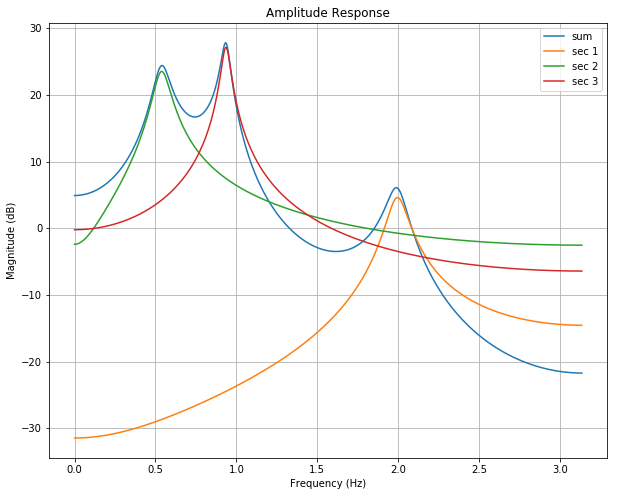

In [2]:
import numpy as np
from scipy.signal import residuez, freqz, lfilter
import matplotlib.pyplot as plt
%matplotlib inline

F = np.array([700, 1220, 2600]) # formant frequencies (Hz)
BW = np.array([130, 70, 160]) # formant bandwidths (Hz)
fs = 8192 # sampling rate (Hz)

num_sections = len(F)
R = np.exp(-np.pi * BW / fs) # pole radii
theta = 2 * np.pi * F / fs # pole angles
poles = R * np.exp(1j * theta) # complex poles
B = np.array([1]); A = np.real(np.poly(np.append(poles, np.conj(poles)))) # compute transfer function coefficients

# Convert to parallel complex one-poles (PFE):
r,p,f = residuez(B, A)
As = np.zeros((num_sections, 3), dtype=complex)
Bs = np.zeros((num_sections, 3), dtype=complex)
# Complex-conjugate pairs are adjacent in r and p
for i in range(0, 2 * num_sections, 2):
    k = i//2
    Bs[k,:] = [r[i] + r[i+1], -(r[i] * p[i+1] + r[i+1] * p[i]), 0]
    As[k,:] = [1, -(p[i] + p[i+1]), p[i] * p[i+1]]

sos = np.hstack([Bs, As]) # standard second-order section form
iperr = np.linalg.norm(sos.imag) / np.linalg.norm(sos) # make sure `sos` is approx. real
print('||imag(sos)||/||sos|| = %g' % iperr)
sos = sos.real # and make it exactly real

# Reconstruct original numerator and denominator as a check:
Bh, Ah = psos2tf(sos)
print('||A-Ah|| = %g', np.linalg.norm(A-Ah))
print('||B-Bh|| = %g', np.linalg.norm(np.append(B, np.zeros(len(Bh) - len(B)))-Bh))

# Plot overlay and sum of all three resonator amplitude responses:
nfft=512
H = np.zeros((num_sections+1, nfft), dtype=complex)
for i in range(num_sections):
    w, H_iw = freqz(Bs[i,:],As[i,:])
    H[i + 1,:] = H_iw[:].transpose()

H[0,:] = np.sum(H[1:num_sections + 1,:], axis=0)

plt.figure(figsize=(10, 8))
plt.title('Amplitude Response');
plt.ylabel('Magnitude (dB)');
plt.xlabel('Frequency (Hz)');
labels = ['sum','sec 1','sec 2', 'sec 3']
for i, y in enumerate(20*np.log10(np.abs(H))):
    plt.plot(w, y, label=labels[i])
plt.legend()
plt.grid(True)

# Now synthesize the vowel 'a':
num_samples = 1 * fs
f0 = 200 # Pitch in Hz
w0T = 2*np.pi*f0/fs # radians per sample

num_harmonics = int(np.floor((fs/2)/f0))
signal = np.zeros(num_samples)
n = np.arange(0, num_samples)
# Synthesize bandlimited impulse train
for i in range(num_harmonics):
    signal += np.cos(i*w0T*n)

signal = signal / signal.max()
speech = lfilter([1], A, signal)

_Compare with Fig. 9.6 on p214._

In [3]:
from IPython.display import Audio

Audio(np.append(signal, speech), rate=fs) # buzz, then 'ah'

### Butterworth Lowpass FIlter Example

Implement a 5th-order Butterworth lowpass filter, using second-order sections. ([p215 in the book](https://ccrma.stanford.edu/~jos/filters/Butterworth_Lowpass_Filter_Example.html))

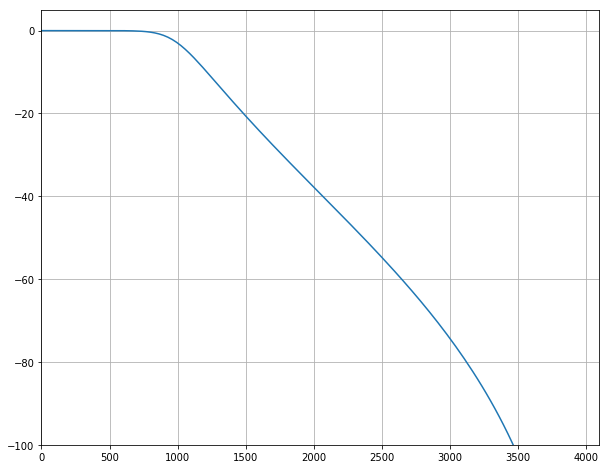

In [4]:
from scipy.signal import butter, tf2sos

fc = 1000 # Cut-off frequency (Hz)
fs = 8192 # Sampling rate (Hz)
order = 5 # Filter order
B, A = butter(order,2*fc/fs); # [0:pi] maps to [0:1] here
sos = tf2sos(B,A)

# Compute and display the amplitude response
Bs = sos[:,0:3] # Section numerator polynomials
As = sos[:,3:]  # Section denominator polynomials
num_sections, _ = sos.shape
num_samples = 256 # Number of impulse-response samples
# Note use of input scale-factor g here:
x = np.append([1], np.zeros(num_samples - 1)) # SCALED impulse signal
for i in range(num_sections):
    x = lfilter(Bs[i,:], As[i,:], x) # Series sections (can also use `sosfilt` to avoid manually unpacking)

# Plot amplitude response 
plt.figure(figsize=(10, 8));
X = np.fft.fft(x) # sampled frequency response
f = np.arange(num_samples) * fs / num_samples
plt.grid(True)
plt.axis([0, fs / 2, -100, 5])
_ = plt.plot(f[:num_samples//2], 20 * np.log10(np.abs(X[:num_samples // 2])))

_Compare with Fig. 9.7 on p216._

## Filter Structure Problems

**1. a) Draw the general first-order IIR digital filter in _direct-form II_.**

(a) and (b) are drawn below

**b) Derive the _transpose_ of this filter by reversing all the arrows and interchanging summers and branch-poins as needed.**

![](first_order_iir_drawing.jpg)

**c) Derive the _transfer function_ of the transposed DF-II first-order filter (show your work).**

We can read the difference equation directly from the second diagram as

$s_1(n) = b_1x(n-1) - a_1y(n-1)\\
y(n) = b_0x(n) + s_1(n).$

If we substitute for the single state variable $s_1$, we get the usual form of the IIR difference equation:

$y(n) = b_0x(n) + b_1x(n-1) - a_1y(n-1)$.

The transfer function is the usual one:

$\begin{align}
H(z) &= \frac{Y(z)}{X(z)}\\
&= \frac{b_0 + b_1z^{-1}}{1 + a_1z^{-1}}.\\
\end{align}$

The derivation can be found in the book [in chapter 6 - Z Transform of Difference Equations](https://ccrma.stanford.edu/~jos/fp/Z_Transform_Difference_Equations.html).

**2. Draw the general TDF-1 filter structure.**

![](./general_tdf1_drawing.png)

**3. Derive the _difference equation_ for the second-order TDF-1 structure depicted in [Fig 9.3](https://ccrma.stanford.edu/~jos/fp/Transposed_Direct_Forms.html#fig:tdfi), using the signal labels shown in the figure.**

![](https://ccrma.stanford.edu/~jos/fp/img1145.png)

_(Note - I used the same convention for the general TDF-1 filter structure drawing above.)_

The difference equation can be read off of the diagram as

$s_2(n) = -a_2x(n-2)\\
s_1(n) = s_2(n) - a_1x(n-1)\\
v(n) = x(n) + s_1(n)\\
s_4(n) = b_2v(n-2)\\
s_3(n) = s_4(n) + b_1v(n-1)\\
y(n) = b_0v(n) + s_3(n)\\
$

The state variables are given in the order of their dependencies, which is more mathematically conventional, but it's worth noting that in a software implementation would typically declare the state variables as single values (as opposed to an array) in the reverse order, so that delays can be calculated by simply using the delayed variables before updating them.

**4. Derive the _difference equation_ for the second-order TDF-II structure depicted in [Fig. 9.4](https://ccrma.stanford.edu/~jos/fp/Transposed_Direct_Forms.html#fig:tdfii), using the signal labels shown in the figure.**

![](https://ccrma.stanford.edu/~jos/fp/img1146.png)

The difference equation is:

$s_2(n) = b_2x(n-2) - a_2y(n-2)\\
s_1(n) = s_2(n) + b_1x(n-1) - a_1y(n-1)\\
y(n) = b_0x(n) + s_1(n).$

**5. Derive the _difference equation_ for the second-order TDF-1 structure depicted in Fig. 9.3, using the signal labels shown in the figure.**

_This is the same question as **(3)** above._

**6. Consider the following 9th-order digital filter having all nine zeros at $z=1$ and all nine poles at $z=0.9$:**

`[B, A] = zp2tf(ones(10, 1), 0.9*ones(10, 1), 1);`

**a) Write matlab code to find the maximum relative error in the magnitudes of the zeros and poles:**

`[z,p,g] = tf2zp(B, A);`


In [5]:
from scipy.signal import zpk2tf, tf2zpk

z_actual = np.ones(10)
p_actual = np.full(10, 0.9)

B, A = zpk2tf(z_actual, p_actual, 1)
z_est, p_est, k = tf2zpk(B, A)

max_relative_zero_error = np.max((np.abs(z_est) - np.abs(z_actual)) / np.abs(z_actual))
max_relative_pole_error = np.max((np.abs(p_est) - np.abs(p_actual)) / np.abs(p_actual))

print('Maximum relative error in magnitude of zeros: %g' % max_relative_zero_error)
print('Maximum relative error in magnitude of poles: %g' % max_relative_pole_error)

Maximum relative error in magnitude of zeros: 0.049239
Maximum relative error in magnitude of poles: 0.0554031


**b) Write matlab code to find the maximum relative error in the filter coefficients reconstructed from a series second-order factorization:**

```
[sos, g] = tf2sos(B, A);
[Bh, Ah] = sos2tf(sos, g);
```

In [6]:
from scipy.signal import sos2tf

sos = tf2sos(B, A)
B_est, A_est = sos2tf(sos)

max_relative_B_error = np.max((np.abs(B_est) - np.abs(B)) / np.abs(B))
max_relative_A_error = np.max((np.abs(A_est) - np.abs(A)) / np.abs(A))

print('Maximum relative error in magnitude of A coefficients: %g' % max_relative_A_error)
print('Maximum relative error in magnitude of B coefficients: %g' % max_relative_B_error)

Maximum relative error in magnitude of A coefficients: 9.07465e-15
Maximum relative error in magnitude of B coefficients: 0


**7. Find an example first-order real IIR digital filter having at least one coefficient with a nonzero imaginary part. In other words, find a filter transfer function having at least one necessarily complex coefficient that behaves as a real filter.**

If there is a way to achieve a real response to a real signal with at most one zero and at most one pole, I cannot seem to find it. If we take the second sentence as the real requirement, _"find a filter transfer function having at least one necessarily complex coefficient that behaves as a real filter,"_ this is easy to do by pairing zeros and poles with their complex conjugates:

$H(z) = \frac{\left(1 - q_1z^{-1}\right)\left(1 - \overline{q_1}z^{-1}\right)}{\left(1 - p_1z^{-1}\right)\left(1 - \overline{p_1}z^{-1}\right)} = \frac{1 - \left(q_1 + \overline{q_1}\right)z^{-1} + q_1\overline{q_1}z^{-2}}{1 - \left(p_1 + \overline{p_1}\right)z^{-1} + p_1\overline{p_1}z^{-2}} = \frac{1 - 2\text{Re}\{q_1\}z^{-1} + \left|q_1\right|^2z^{-2}}{1 - 2\text{Re}\{p_1\}z^{-1} + \left|p_1\right|^2z^{-2}}$

Here is an example:

In [7]:
from scipy.signal import zpk2tf

r = 0.5
w = 0.2
z = [np.exp(1j * w), np.exp(-1j * w)];
p = [r * np.exp(1j * w), r * np.exp(-1j * w)]
B, A = zpk2tf(z, p, 1)
impulse = [1.0] + [0] * 99
h = lfilter(B, A, impulse)
print('Sum of imaginary component of impulse response: %0.3f' % np.sum(h.imag))

Sum of imaginary component of impulse response: 0.000


**8. Consider a second-order digital allpass filter with poles located at $z = \pm gj, 0 < g < 1$:**

$H(z) = \frac{g^2 + z^{-2}}{1 + g^2z^{-2}}$

**a) Draw a realization of this filter in direct-form II (DF-II).**

(Drawings for **a** and **b** below.)

**b) Draw a realization of this filter in transposed direct-form II (TDF-II).**

![](./ch_9_problem_8_drawing.png)

**c) For a unit amplitude dc input signal (_i.e._, the input signal is a constant, $x(n) = 1$ for all $n > 0$), find the maximum internal amplitude in the DF-II structure (in the limit as $n \to \infty$).**

Let's find the difference equation:

$v(n) = x(n) - g^2v(n-2)\\
y(n) = g^2v(n) + v(n-2)$

To find the maximum "internal amplitude", we find the value of the state variable $v(n)$ as $n \to \infty$.  Let's just expand out a few of the terms to see if we can find a pattern (immediately substituting all $x(n)$ with $1$ to save space):

$\begin{align}
v(n) &= 1 - g^2v(n-2)\\
&= 1 - g^2\left(1 - g^2v(n-4)\right)\\
&= 1 - g^2\left(1 - g^2\left(1 - g^2v(n-6)\right)\right)\\
&= 1 - g^2\left(1 - g^2\left(1 - g^2\left(1 - g^2v(n-8)\right)\right)\right)\\
&= 1 - g^2\left(1 - g^2\left(1 - g^2 + g^4v(n-8)\right)\right)\\
&= 1 - g^2\left(1 - g^2 + g^4 - g^6v(n-8)\right)\\
&= 1 - g^2 + g^4 - g^6 + g^8v(n-8)\\
&= 1 - g^2 + g^4 - g^6 + g^8 - \cdots\\
&= \sum_\limits{m=0}^{n/2}\left(-1\right)^{m}g^{2m}
\end{align}$

If $g > 1$, this limit is unbounded. If $g < 1$, it approaches $0$.

**d) Repeat the previous problem for the TDF-II structure.**

Finding the difference equation:

$s_1(n) = x(n-2) - g^2y(n-2)\\
y(n) = g^2x(n) + s_1(n).$

Let's do the same thing for the state variable $s_1$, expanding several terms to see if we can find a pattern:

$\begin{align}
s_1(n) &= 1 - g^2y(n-2)\\
&= 1 - g^2\left(g^2 + s_1(n-2)\right)\\
&= 1 - g^4 - g^2s_1(n-2)\\
&= 1 - g^4 - g^2\left(1 - g^2y(n-4)\right)\\
&= 1 - g^4 - g^2 + g^4y(n-4)\\
&= 1 - g^4 - g^2 + g^4\left(g^2 + s_1(n-4)\right)\\
&= 1 - g^4 - g^2 + g^6 + g^4s_1(n-4)\\
&= 1 - g^4 - g^2 + g^6 + g^4\left(1 - g^2y(n-6)\right)\\
&= 1 - g^4 - g^2 + g^6 + g^4 - g^6y(n-6)\\
&= 1 - g^2 + g^6 - g^6\left(g^2 + s_1(n-6)\right)\\
&= 1 - g^2 + g^6 - g^8 - g^6s_1(n-6)\\
&= 1 - g^2 + g^6 - g^8 - g^6\left(1 - g^2y(n-8)\right)\\
&= 1 - g^2 + g^6 - g^8 - g^6 + g^8y(n-8)\\
&= 1 - g^2 - g^8 + g^8\left(g^2 + s_1(n-8)\right)\\
&= 1 - g^2 - g^8 + g^{10} + g^8s_1(n-8)\\
&= 1 - g^2 - g^8 + g^{10} + g^8\left(1 - g^2y(n-10)\right)\\
&= 1 - g^2 - g^8 + g^{10} + g^8 - g^{10}y(n-10)\\
&= 1 - g^2 + g^{10} - g^{10}\left(g^2 + s_1(n-10)\right)\\
&= 1 - g^2 + g^{10} - g^{12} - g^{10}s_1(n-10)\\
&= 1 - g^2 + g^{10} - g^{12} - g^{10}\left(1 - g^2y(n-12)\right)\\
&= 1 - g^2 + g^{n-1}\\
\end{align}$

In [11]:
def df_2(x, g=2):
    y = np.zeros(x.size)
    internal_state = np.zeros(x.size)
    v = 0
    v_1 = 0
    v_2 = 0
    for n in range(x.size):
        v = x[n] - g ** 2 * v_2
        y[n] = g ** 2 * v + v_2
        v_2 = v_1
        v_1 = v
        internal_state[n] = v
    return y, internal_state

In [12]:
def tdf_2(x, g=2):
    y = np.zeros(x.size)
    internal_state = np.zeros(x.size)
    s_1 = 0
    x_1 = 0
    x_2 = 0
    y_1 = 0
    y_2 = 0
    for n in range(x.size):
        s_1 = x_2 - g ** 2 * y_2
        y[n] = g **2 * x[n] + s_1
        x_2 = x_1
        x_1 = x[n]
        y_2 = y_1
        y_1 = y[n]
        internal_state[n] = s_1
    return y, internal_state

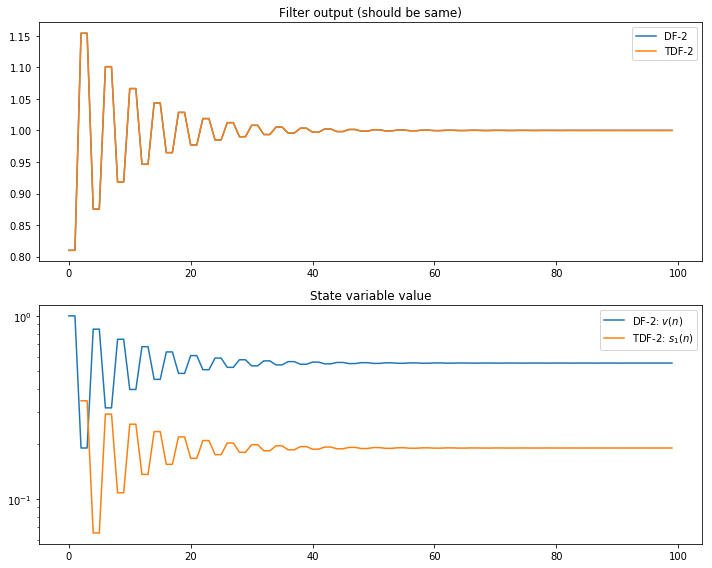

In [16]:
y_df2, internal_state_df2 = df_2(np.ones(100), 0.9)
y_tdf2, internal_state_tdf2 = tdf_2(np.ones(100), 0.9)
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(y_df2, label='DF-2')
plt.plot(y_tdf2, label='TDF-2')
plt.title('Filter output (should be same)')
plt.legend()
plt.subplot(212)
plt.semilogy(internal_state_df2, label='DF-2: $v(n)$')
plt.semilogy(internal_state_tdf2, label='TDF-2: $s_1(n)$')
plt.title('State variable value')
plt.legend()
plt.tight_layout()

**e) Briefly discuss the meaning and implications of your results.**

In the DF-2 implementation, the pole is "encountered" first internally. If $g < 1$, this causes an "expansion" of the input value (it grows). If $g > 1$, this results in a shrinking of the input value. In the TDF-2 implementation, the zero is encountered before the pole, and we see the opposite effect. Thus, when $g < 1$, the DF-2 implementation has larger maximum internal magnitude, and when $g > 1$, the TDF-2 implementation has the larger maximum.